In [20]:
import os
import sys
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.utils import resample

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils

from sklearn import metrics

from sklearn.model_selection import train_test_split 

from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
max_pad_len = 68

def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print (mfccs.shape)
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [23]:
def print_prediction(file_name):
    prediction_feature = np.array([extract_features(file_name)]) 
        
    if(prediction_feature.any() == None):
        return
        
    prediction_feature = prediction_feature.reshape(prediction_feature.shape[0], 40, max_pad_len, 1)
    
    np.savetxt("prediction_feature.txt",prediction_feature.reshape(-1))
    
    predicted_vector = np.argmax(model.predict(prediction_feature), axis=1)
    
    predicted_class = le.inverse_transform(predicted_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
        
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

In [37]:
# Read csv file 
train_filename = pd.read_csv("new_train.csv")

train_filename = train_filename[(train_filename.manually_verified == 1)]

bark_filename = train_filename[(train_filename.label == "Bark")]
not_bark_filename = train_filename[(train_filename.label != "Bark")]
not_bark_filename.loc[not_bark_filename.label != "Bark", 'label'] = "Not_bark"

# Upsample minority class
not_bark_filename = resample(not_bark_filename, 
                         replace=False,     # sample with replacement
                         n_samples=bark_filename.shape[0],    # to match majority class
                         random_state=123) # reproducible results

# Combine majority class with upsampled minority class
train_filename = pd.concat([not_bark_filename, bark_filename])
 
# Display new class counts
train_filename.label.value_counts()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


Not_bark    199
Bark        199
Name: label, dtype: int64

In [38]:
train_features = []

# Iterate through each sound file and extract the features
for index, row in train_filename.iterrows():
    
    file_name_train = "./audio_train/" + str(row["fname"])
    
    class_label = row["label"]
    data = extract_features(file_name_train)
    
    train_features.append([data, class_label])
    
    
# Convert into a Panda dataframe 
train_featuresdf = pd.DataFrame(train_features, columns=['feature','label'])
train_featuresdf = train_featuresdf.dropna()
print('Finished feature extraction from ', len(train_featuresdf), ' files')

Finished feature extraction from  398  files


In [39]:
### store the preprocessed data for use in the next notebook

%store train_featuresdf 

Stored 'train_featuresdf' (DataFrame)


In [6]:
# retrieve the preprocessed data from previous notebook

%store -r train_featuresdf 

In [7]:
# Convert features and corresponding classification labels into numpy arrays
X = np.array(train_featuresdf.feature.tolist())
y = np.array(train_featuresdf.label.tolist())

# Encode the classification labels
le = LabelEncoder()

y = to_categorical(le.fit_transform(y)) 

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [41]:
%store x_train
%store x_test
%store y_train
%store y_test

Stored 'x_train' (ndarray)
Stored 'x_test' (ndarray)
Stored 'y_train' (ndarray)
Stored 'y_test' (ndarray)


In [4]:
%store -r x_train
%store -r x_test
%store -r y_train
%store -r y_test

In [48]:
num_rows = 40
num_columns = 68
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = y_test.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

In [49]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [50]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 39, 67, 16)        80        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 19, 33, 16)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 19, 33, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 18, 32, 32)        2080      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 9, 16, 32)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 9, 16, 32)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 15, 64)        

In [46]:
x_train.shape

(318, 40, 68, 1)

In [51]:
num_epochs = 200
num_batch_size = 53

checkpointer = ModelCheckpoint(filepath='dog_bark_downbalanced.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model_history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/200
6/6 [==============================] - 2s 175ms/step - loss: 7.9489 - accuracy: 0.4748 - val_loss: 2.8679 - val_accuracy: 0.4250

Epoch 00001: val_loss improved from inf to 2.86786, saving model to dog_bark_downbalanced.hdf5
Epoch 2/200
6/6 [==============================] - 1s 136ms/step - loss: 4.8680 - accuracy: 0.5157 - val_loss: 1.5947 - val_accuracy: 0.5750

Epoch 00002: val_loss improved from 2.86786 to 1.59468, saving model to dog_bark_downbalanced.hdf5
Epoch 3/200
6/6 [==============================] - 1s 111ms/step - loss: 3.2912 - accuracy: 0.5692 - val_loss: 1.2379 - val_accuracy: 0.5500

Epoch 00003: val_loss improved from 1.59468 to 1.23792, saving model to dog_bark_downbalanced.hdf5
Epoch 4/200
6/6 [==============================] - 1s 121ms/step - loss: 2.0658 - accuracy: 0.5943 - val_loss: 1.2677 - val_accuracy: 0.5750

Epoch 00004: val_loss did not improve from 1.23792
Epoch 5/200
6/6 [==============================] - 1s 124ms/step - loss: 1.7247 - accura

6/6 [==============================] - 1s 181ms/step - loss: 0.1260 - accuracy: 0.9591 - val_loss: 0.1086 - val_accuracy: 0.9250

Epoch 00077: val_loss improved from 0.10918 to 0.10858, saving model to dog_bark_downbalanced.hdf5
Epoch 78/200
6/6 [==============================] - 1s 159ms/step - loss: 0.1416 - accuracy: 0.9497 - val_loss: 0.1064 - val_accuracy: 0.9375

Epoch 00078: val_loss improved from 0.10858 to 0.10643, saving model to dog_bark_downbalanced.hdf5
Epoch 79/200
6/6 [==============================] - 1s 168ms/step - loss: 0.1002 - accuracy: 0.9560 - val_loss: 0.1215 - val_accuracy: 0.9375

Epoch 00079: val_loss did not improve from 0.10643
Epoch 80/200
6/6 [==============================] - 1s 163ms/step - loss: 0.0898 - accuracy: 0.9717 - val_loss: 0.1009 - val_accuracy: 0.9625

Epoch 00080: val_loss improved from 0.10643 to 0.10086, saving model to dog_bark_downbalanced.hdf5
Epoch 81/200
6/6 [==============================] - 1s 143ms/step - loss: 0.0955 - accuracy: 


Epoch 00116: val_loss did not improve from 0.06034
Epoch 117/200
6/6 [==============================] - 1s 146ms/step - loss: 0.0509 - accuracy: 0.9811 - val_loss: 0.0543 - val_accuracy: 0.9875

Epoch 00117: val_loss improved from 0.06034 to 0.05428, saving model to dog_bark_downbalanced.hdf5
Epoch 118/200
6/6 [==============================] - 1s 128ms/step - loss: 0.0511 - accuracy: 0.9874 - val_loss: 0.0636 - val_accuracy: 0.9875

Epoch 00118: val_loss did not improve from 0.05428
Epoch 119/200
6/6 [==============================] - 1s 136ms/step - loss: 0.0517 - accuracy: 0.9811 - val_loss: 0.0539 - val_accuracy: 0.9875

Epoch 00119: val_loss improved from 0.05428 to 0.05389, saving model to dog_bark_downbalanced.hdf5
Epoch 120/200
6/6 [==============================] - 1s 118ms/step - loss: 0.0439 - accuracy: 0.9811 - val_loss: 0.0634 - val_accuracy: 0.9875

Epoch 00120: val_loss did not improve from 0.05389
Epoch 121/200
6/6 [==============================] - 1s 128ms/step - los

6/6 [==============================] - 1s 123ms/step - loss: 0.0280 - accuracy: 0.9906 - val_loss: 0.0579 - val_accuracy: 0.9750

Epoch 00157: val_loss did not improve from 0.04165
Epoch 158/200
6/6 [==============================] - 1s 181ms/step - loss: 0.0264 - accuracy: 0.9937 - val_loss: 0.0590 - val_accuracy: 0.9875

Epoch 00158: val_loss did not improve from 0.04165
Epoch 159/200
6/6 [==============================] - 1s 228ms/step - loss: 0.0548 - accuracy: 0.9780 - val_loss: 0.0485 - val_accuracy: 0.9875

Epoch 00159: val_loss did not improve from 0.04165
Epoch 160/200
6/6 [==============================] - 1s 125ms/step - loss: 0.0271 - accuracy: 0.9874 - val_loss: 0.0472 - val_accuracy: 0.9875

Epoch 00160: val_loss did not improve from 0.04165
Epoch 161/200
6/6 [==============================] - 1s 188ms/step - loss: 0.0450 - accuracy: 0.9811 - val_loss: 0.0447 - val_accuracy: 0.9875

Epoch 00161: val_loss did not improve from 0.04165
Epoch 162/200
6/6 [====================

6/6 [==============================] - 1s 114ms/step - loss: 0.0124 - accuracy: 0.9937 - val_loss: 0.1032 - val_accuracy: 0.9500

Epoch 00199: val_loss did not improve from 0.04144
Epoch 200/200
6/6 [==============================] - 1s 127ms/step - loss: 0.0194 - accuracy: 0.9874 - val_loss: 0.0674 - val_accuracy: 0.9875

Epoch 00200: val_loss did not improve from 0.04144
Training completed in time:  0:03:07.032496


In [8]:
model = load_model("dog_bark_downbalanced.hdf5")

In [55]:

yy_test = y_test[:,1]
xx_test = np.vstack(x_test)

# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])



Training Accuracy:  0.9842767119407654
Testing Accuracy:  0.987500011920929


In [24]:
filename = "./audio_test/2fefb864.wav"
print_prediction(filename) 
    

The predicted class is: Bark 

Bark 		 :  0.99999511241912841796875000000000
Not_bark 		 :  0.00000489506646772497333586215973


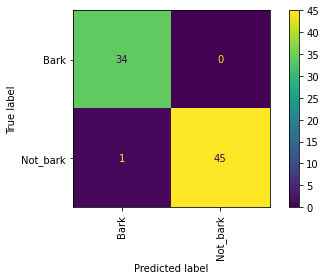

In [58]:
y_pred = model.predict_classes(x_test)


cm = confusion_matrix(y_test[:,1], y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=le.classes_)
disp.plot()

cm_fig = disp.figure_
cm_ax = disp.ax_
cm_ax.tick_params(axis='x', rotation=90)
#cm_fig.set_size_inches(20, 20)

cm_fig.tight_layout()
cm_fig.savefig("./test.png",  dpi=600)


In [12]:
y_test[:,1].shape

(1348,)